In [1]:
import pandas as pd
import pandasai as pai
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv('../data/catboost_data.csv')

In [3]:
today = datetime(2024, 12, 29)  # Assuming "Added yesterday" refers to 28/12/2024
yesterday = today - timedelta(days=1)

# Step 2. Clean function
def normalize_date(x):
    x = x.strip()
    if "Added yesterday" in x:
        return yesterday.strftime("%d/%m/%Y")
    elif "Reduced on" in x:
        # Extract date after the phrase
        parts = x.split("Reduced on")[-1].strip()
        return parts
    else:
        return x

In [4]:
df["added_on"] = df["added_on"].apply(normalize_date)

In [6]:
df["added_on"].value_counts()

added_on
03/01/2025    1569
02/01/2025    1565
28/12/2024    1028
17/12/2024     679
10/12/2024     663
              ... 
01/12/2023       1
28/03/2023       1
28/10/2019       1
03/01/2023       1
30/06/2023       1
Name: count, Length: 546, dtype: int64

In [7]:
df.to_csv("../data/catboost_data2.csv", index=False)

In [2]:
df = pd.read_parquet("../data/catboost_data.parquet",engine="pyarrow")

In [4]:
df["price"].sum()/0.0445

2010583146.0674157

In [6]:
numerical_features = ["latitude", "longitude","distance_to_center","angle_from_center","distance_to_station1","distance_to_station2","distance_to_station3"]
categorical_features = ["bedrooms","bathrooms","deposit","zone","borough","propertyType","furnishType","NoiseClass","letType", "TFL1", "TFL2", "TFL3", "RAIL1", "RAIL2","RAIL3"]

# if NLP_clusters:
#     categorical_features.append("nlp_cluster")
features = numerical_features+categorical_features
target = "price"

model_path = "../models/catboost_model_v1.cbm"

pricing_model = CatBoostRegressor()
pricing_model.load_model(model_path)

y_pred = pricing_model.predict(df[features])

In [7]:
df["predicted_price"] = y_pred
df["pricing_index"] = df["price"]/df["predicted_price"]

<Axes: >

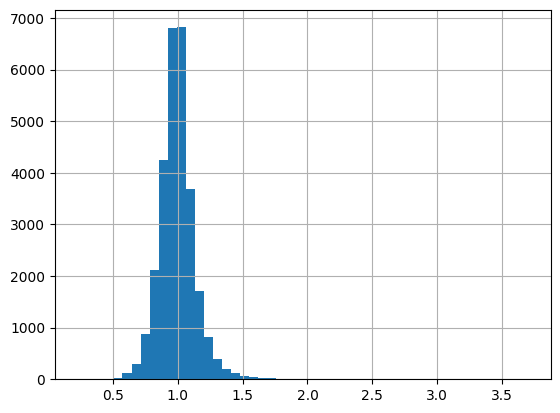

In [10]:
df["pricing_index"].hist(bins=50)

In [11]:
drop_columns = [
    "geometry",
    "color",
    "angle_from_center",
    "hex_id",
    "TFL1",
    "TFL2",
    "TFL3",
    "index_rows",
    "embeddings",
    "RAIL1",
    "RAIL2",
    "RAIL3",
    "description"]


df = df.drop(columns=drop_columns)
df.rename(columns={"clean_description": "description"}, inplace=True)

In [12]:
df

,id,title,displayAddress,outcode,incode,bathrooms,bedrooms,propertyType,price,secondaryPrice,...,station_type3,borough,zone,distance_to_center,index_right,NoiseClass,zone_hex,description,predicted_price,pricing_index
0,156331799,"3 bedroom apartment for rent in Albany Court, ...","Albany Court, Spring Grove, London, W4",W4,3BF,3,3,Apartment,3550,819,...,[TFL],Hounslow,3,6.980505,20867.0,>=75.0,Zone 3,"An exceptional 1,080 sq ft, three bedroom, thr...",4248.351722,0.835618
1,156345644,2 bedroom terraced house for rent in Peal Gard...,"Peal Gardens, Greenford, Middlesex, W13",W13,0BA,1,2,Terraced,2097,484,...,[TFL],Ealing,4,8.765145,14254.0,0,Zone 4,Video tour available: \nA modern 2 Bedrooms h...,1971.855626,1.063465
2,153523199,"2 bedroom flat for rent in Blackfriars Road, S...","Blackfriars Road, Southwark, London, SE1",SE1,8EW,2,2,Flat,5800,1338,...,[TFL],Southwark,1,1.146696,24418.0,>=75.0,Zone 1,SHORT LET. Set in an exceptional new developme...,5243.815747,1.106065
3,155610035,3 bedroom terraced house for rent in Springfie...,"Springfield Place, Hornbeam Mews, SW17",SW17,7DJ,3,3,Terraced,3100,715,...,[NATIONAL_TRAIN],Wandsworth,3,5.216208,276.0,0,Zone 3,"Regent excited to offer this spacious, bright ...",3462.593661,0.895283
4,155840024,"1 bedroom flat for rent in Upper Street, Angel...","Upper Street, Angel, London, N1",N1,2XQ,1,1,Flat,2500,577,...,"[TFL, NATIONAL_TRAIN]",Islington,2,2.327834,654.0,70.0-74.9,Zone 2,LONG LET. Situated within highly sought-after ...,2353.953234,1.062043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28483,155845379,"1 bedroom flat for rent in Draycott Place, Che...","Draycott Place, Chelsea, SW3",SW3,3BP,1,1,Flat,2752,635,...,[TFL],Kensington and Chelsea,1,1.886673,16202.0,70.0-74.9,Zone 1,An excellent one bedroom flat situated on the ...,3447.415903,0.798279
28484,155613146,"1 bedroom apartment for rent in Apartment , N...","Apartment , Nine Elms Lane, London",SW8,5HE,1,1,Apartment,3900,900,...,[TFL],Wandsworth,1,1.619129,819.0,>=75.0,Zone 1,Leisure Facilities24hr SecurityTwo Double Bedr...,4088.660914,0.953858
28485,155966516,"2 bedroom apartment for rent in Beaufort Road,...","Beaufort Road, St. Johns Court Beaufort Road, KT1",KT1,2TT,1,2,Apartment,1650,381,...,[NATIONAL_TRAIN],Kingston upon Thames,6,10.405954,6871.0,0,Zone 6,Humphrey & Brand are pleased to present this f...,1993.938799,0.827508
28486,97714892,"2 bedroom apartment for rent in Park Street, L...","Park Street, London, W1K",W1K,7JF,2,2,Apartment,7323,1690,...,[TFL],Westminster,1,1.284522,1342.0,>=75.0,Zone 1,"A newly refurbished first floor apartment, fin...",6823.409218,1.073217


In [13]:
# Assuming df is your original DataFrame
rename_map = {
    "displayAddress": "display_address",
    "outcode": "postcode_outcode",
    "incode": "postcode_incode",
    "propertyType": "property_type",
    "secondaryPrice": "secondary_price_gbp",
    "letAvailableDate": "let_available_date",
    "deposit": "deposit_gbp",
    "letType": "let_type",
    "furnishType": "furnish_type",
    "councilTaxExempt": "council_tax_exempt",
    "councilTaxIncluded": "council_tax_included",
    "councilTaxBand": "council_tax_band",
    "features": "property_features",
    "listingUpdateReason": "listing_update_reason",
    "listingUpdateDate": "listing_update_date",
    "firstVisibleDate": "first_visible_date",
    "addedOn": "added_on",
    "sizeSqFeetMin": "size_sqft_min",
    "sizeSqFeetMax": "size_sqft_max",
    "station_name1": "nearest_station1_name",
    "station_name2": "nearest_station2_name",
    "station_name3": "nearest_station3_name",
    "distance_to_station1": "nearest_station1_distance_km",
    "distance_to_station2": "nearest_station2_distance_km",
    "distance_to_station3": "nearest_station3_distance_km",
    "station_type1": "nearest_station1_type",
    "station_type2": "nearest_station2_type",
    "station_type3": "nearest_station3_type",
    "borough": "borough",
    "zone": "travel_zone",
    "distance_to_center": "distance_to_center_km",
    "index_right": "spatial_index",
    "NoiseClass": "noise_level_class",
    "zone_hex": "zone_hex",
    "clean_description": "clean_description",
    "price": "price_gbp"
}

df = df.rename(columns=rename_map)

# check result
print(df.columns.tolist())


['id', 'title', 'display_address', 'postcode_outcode', 'postcode_incode', 'bathrooms', 'bedrooms', 'property_type', 'price_gbp', 'secondary_price_gbp', 'let_available_date', 'deposit_gbp', 'let_type', 'furnish_type', 'council_tax_exempt', 'council_tax_included', 'council_tax_band', 'property_features', 'listing_update_reason', 'listing_update_date', 'first_visible_date', 'added_on', 'size_sqft_min', 'size_sqft_max', 'latitude', 'longitude', 'nearest_station1_name', 'nearest_station2_name', 'nearest_station3_name', 'nearest_station1_distance_km', 'nearest_station2_distance_km', 'nearest_station3_distance_km', 'nearest_station1_type', 'nearest_station2_type', 'nearest_station3_type', 'borough', 'travel_zone', 'distance_to_center_km', 'spatial_index', 'noise_level_class', 'zone_hex', 'description', 'predicted_price', 'pricing_index']


In [8]:
drop_columns = [
    "zone_hex",
    "spatial_index"
]

df = df.drop(columns=drop_columns)

df.rename(columns={"clean_description": "property_description","deposit_gdp":"deposit_included_or_not"}, inplace=True)


In [15]:
# Example distribution you gave
mapping = {
    "55.0-59.9": "low",
    "60.0-64.9": "medium-low",
    "65.0-69.9": "medium",
    "70.0-74.9": "medium-high",
    ">=75.0": "high",
    "0": "no_data"   # if you have '0' as a placeholder
}

df["noise_level_class"] = df["noise_level_class"].map(mapping)

In [16]:
df.rename(columns={"deposit_gbp":"deposit_included_or_not"}, inplace=True)

In [18]:
df.columns

Index(['id', 'title', 'display_address', 'postcode_outcode', 'postcode_incode',
       'bathrooms', 'bedrooms', 'property_type', 'price_gbp',
       'secondary_price_gbp', 'let_available_date', 'deposit_included_or_not',
       'let_type', 'furnish_type', 'council_tax_exempt',
       'council_tax_included', 'council_tax_band', 'property_features',
       'listing_update_reason', 'listing_update_date', 'first_visible_date',
       'added_on', 'size_sqft_min', 'size_sqft_max', 'latitude', 'longitude',
       'nearest_station1_name', 'nearest_station2_name',
       'nearest_station3_name', 'nearest_station1_distance_km',
       'nearest_station2_distance_km', 'nearest_station3_distance_km',
       'nearest_station1_type', 'nearest_station2_type',
       'nearest_station3_type', 'borough', 'travel_zone',
       'distance_to_center_km', 'spatial_index', 'noise_level_class',
       'zone_hex', 'description', 'predicted_price', 'pricing_index'],
      dtype='object')

In [19]:
df.to_csv("../data/catboost_data.csv", index=False)

In [8]:
file = pai.read_csv("../data/catboost_data2.csv")

In [3]:
# Semantic DataFrame
df_ai = pai.create(
    path="new-bot/rental-data-london3",
    df=file,
    description="London real estate property listings with pricing, size, location, station proximity, and noise levels",
    columns=[
        {"name": "id", "type": "string", "description": "Unique identifier for each property listing"},
        {"name": "title", "type": "string", "description": "Listing title"},
        {"name": "display_address", "type": "string", "description": "Readable address of the property"},
        {"name": "postcode_outcode", "type": "string", "description": "Outcode part of the UK postcode"},
        {"name": "postcode_incode", "type": "string", "description": "Incode part of the UK postcode"},
        {"name": "bathrooms", "type": "integer", "description": "Number of bathrooms"},
        {"name": "bedrooms", "type": "integer", "description": "Number of bedrooms"},
        {"name": "property_type", "type": "string", "description": "Type of property (flat, apartment, house, etc.)"},
        {"name": "price_gbp", "type": "float", "description": "Listed price in GBP"},
        {"name": "secondary_price_gbp", "type": "float", "description": "Secondary listing price (e.g. weekly rent) in GBP"},
        {"name": "let_available_date", "type": "datetime", "description": "Date property is available to let, if known"},
        {"name": "deposit_included_or_not", "type": "string", "description": "Deposit included or (e.g "},
        {"name": "let_type", "type": "string", "description": "Letting type (short term, long term)"},
        {"name": "furnish_type", "type": "string", "description": "Furnishing type (furnished, unfurnished, part furnished)"},
        {"name": "council_tax_exempt", "type": "boolean", "description": "Whether council tax is exempt"},
        {"name": "council_tax_included", "type": "boolean", "description": "Whether council tax is included in rent"},
        {"name": "council_tax_band", "type": "string", "description": "Council tax band classification"},
        {"name": "property_features", "type": "string", "description": "Key features of the property, e.g. garden, parking"},
        {"name": "listing_update_reason", "type": "string", "description": "Reason for most recent listing update"},
        {"name": "listing_update_date", "type": "datetime", "description": "Date of last listing update"},
        {"name": "first_visible_date", "type": "datetime", "description": "Date listing first became visible"},
        {"name": "added_on", "type": "datetime", "description": "Date property was added to the platform"},
        {"name": "size_sqft_min", "type": "float", "description": "Minimum property size in square feet"},
        {"name": "size_sqft_max", "type": "float", "description": "Maximum property size in square feet"},
        {"name": "latitude", "type": "float", "description": "Latitude of the property"},
        {"name": "longitude", "type": "float", "description": "Longitude of the property"},
        {"name": "nearest_station1_name", "type": "string", "description": "Name of the nearest station"},
        {"name": "nearest_station2_name", "type": "string", "description": "Name of the second nearest station"},
        {"name": "nearest_station3_name", "type": "string", "description": "Name of the third nearest station"},
        {"name": "nearest_station1_distance_km", "type": "float", "description": "Distance to nearest station in km"},
        {"name": "nearest_station2_distance_km", "type": "float", "description": "Distance to second nearest station in km"},
        {"name": "nearest_station3_distance_km", "type": "float", "description": "Distance to third nearest station in km"},
        {"name": "nearest_station1_type", "type": "string", "description": "Type of nearest station (tube, national train, DLR, etc.)"},
        {"name": "nearest_station2_type", "type": "string", "description": "Type of second nearest station"},
        {"name": "nearest_station3_type", "type": "string", "description": "Type of third nearest station"},
        {"name": "borough", "type": "string", "description": "London borough of the property"},
        {"name": "travel_zone", "type": "string", "description": "London Travelcard zone"},
        {"name": "distance_to_center_km", "type": "float", "description": "Distance from property to central London (Charing Cross)"},
        {"name": "noise_level_class", "type": "string", "description": "Noise classification (low, medium, high, no_data)"},
        {"name": "description", "type": "string", "description": "Cleaned free-text property description"},
        {"name": "predicted_price", "type": "float",  "description": "Expected price in GBP predicted by a regression model using property features. Serves as a benchmark to compare against the actual listed price."},
        {"name": "pricing_index", "type": "float", "description": "If less than 1, the property is good value. If greater than 1, it is poor value)."}
    ]
)


Dataset saved successfully to path: new-bot/rental-data-london2


In [2]:
import pandas as pd
import ast
import os
import pandasai as pai
from dotenv import load_dotenv

load_dotenv()

# Load PandasAI dataset once at module level
df_ai = pai.load("new-bot/rental-data-london")


response = df_ai.chat("show on map 5 properties in Camden with the lowest pricing index")
print(response)

Dataset loaded successfully.
          id                                              title  \
0  155910110  1 bedroom house share for rent in Clarence Gar...   
1  155931722  2 bedroom apartment for rent in Malden Road, L...   
2  155890334  1 bedroom flat for rent in Pied Bull Court, \n...   
3  155830841  2 bedroom flat for rent in East Heath Road, \n...   
4  156464408  2 bedroom flat for rent in Fordwych Road, Lond...   

                              display_address   latitude  longitude  \
0               Clarence Gardens, London, NW1  51.528088  -0.142130   
1                    Malden Road, London, NW5  51.550300  -0.154362   
2        Pied Bull Court, \nGalen Place, WC1A  51.518563  -0.124067   
3           East Heath Road, \nHampstead, NW3  51.561026  -0.177186   
4  Fordwych Road, London, West Hampstead, NW2  51.551190  -0.206104   

   pricing_index  
0       0.364836  
1       0.556909  
2       0.596303  
3       0.611879  
4       0.617852  


In [4]:
type(response)

pandasai.core.response.dataframe.DataFrameResponse

In [24]:
response = df_ai.chat("What is the average rent for 3-bedroom apartments in Zone 1?")
print(response)

6578.383603238866


<string>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
